# Data 

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns 

import tqdm

## Load Data

In [72]:
x = np.load('input.npy')
y = np.load('target.npy')
print("x.shape:", x.shape)
print("y.shape:", y.shape)

x.shape: (2640, 750, 41)
y.shape: (2640,)


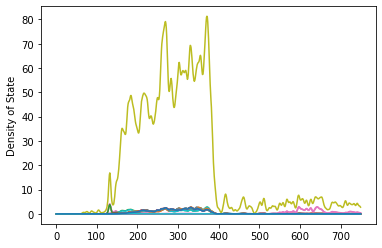

In [73]:
for i in range(1):
#     i = np.random.randint(0, y.shape[0]-1)   
    x_axis = np.arange(0, 750)
    for j in range(x.shape[2]):
        plt.plot(x_axis, x[i, :, j], label="%d"%i)
    plt.ylabel("Density of State")
    plt.show()

## Regularization

In [74]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
scaler = StandardScaler()
x = scaler.fit_transform(x.reshape(-1, x.shape[2])).reshape(x.shape)

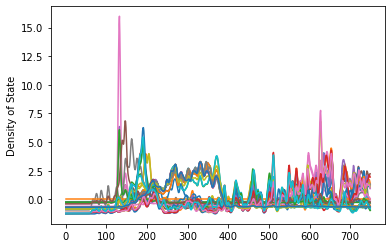

In [75]:
for i in range(1):
#     i = np.random.randint(0, y.shape[0]-1)   
    x_axis = np.arange(0, 750)
    for j in range(x.shape[2]):
        plt.plot(x_axis, x[i, :, j], label="%d"%i)
    plt.ylabel("Density of State")
    plt.show()

## Reshape

In [76]:
x = np.transpose(np.expand_dims(x, axis=1), (0, 1, 3, 2))
print(x.shape)

(2640, 1, 41, 750)


# DOS Model Construction

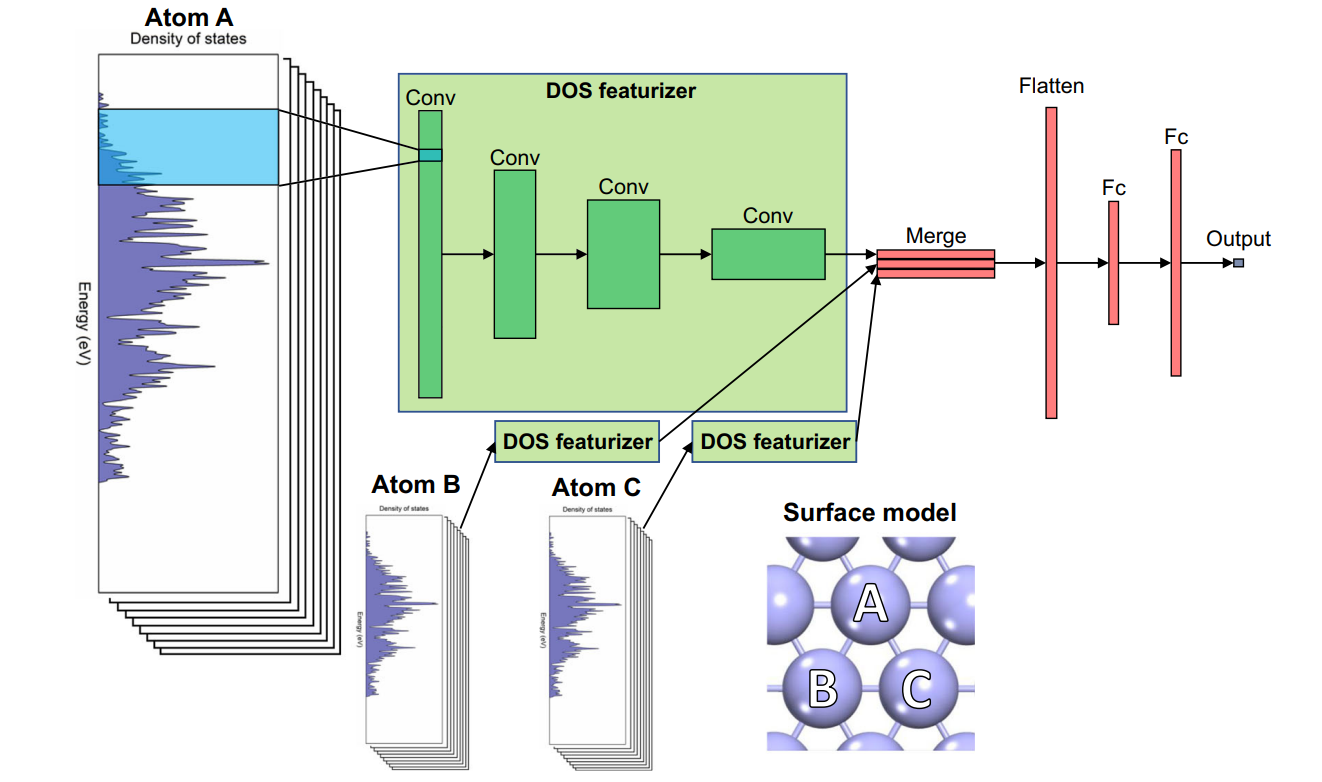

## Model Architecture


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


### DeepConvNet
DOS Model with DeepConvNet

In [22]:
class DeepConvNet(nn.Module):
    def __init__(self):
        super(DeepConvNet, self).__init__()
        self.dropout_rate = 0.5
        
        self.dos_featurizer = nn.Sequential(
            
            nn.Conv2d(1, 25, kernel_size=(1, 5)),
            
            nn.Conv2d(25, 25, kernel_size=(3, 1)),
            nn.BatchNorm2d(25),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),
            
            nn.Conv2d(25, 50, kernel_size=(1, 5)),
            nn.BatchNorm2d(50),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),
            
            nn.Conv2d(50, 100, kernel_size=(1, 5)),
            nn.BatchNorm2d(100),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),

            nn.Conv2d(100, 200, kernel_size=(1, 5)),
            nn.BatchNorm2d(200),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2)),
            nn.Dropout(self.dropout_rate),
            
            nn.Flatten(),
            nn.Linear(335400, 1)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(8600*3, 128),
            nn.ReLU(),
            nn.Linear(128, 1024), 
            nn.ReLU(),
            nn.Linear(1024, 1)
        )
        
        
        
    def forward(self, x):
        
        x = self.dos_featurizer(x)
#         output = torch.cat((output1, output2, output3), 1)
#         output = self.fc(output)
        
        return x
    
model = DeepConvNet().to(device)
summary(model, [(1, 41, 750)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 25, 41, 746]             150
            Conv2d-2          [-1, 25, 39, 746]           1,900
       BatchNorm2d-3          [-1, 25, 39, 746]              50
              ReLU-4          [-1, 25, 39, 746]               0
         MaxPool2d-5          [-1, 25, 39, 373]               0
           Dropout-6          [-1, 25, 39, 373]               0
            Conv2d-7          [-1, 50, 39, 369]           6,300
       BatchNorm2d-8          [-1, 50, 39, 369]             100
              ReLU-9          [-1, 50, 39, 369]               0
        MaxPool2d-10          [-1, 50, 39, 184]               0
          Dropout-11          [-1, 50, 39, 184]               0
           Conv2d-12         [-1, 100, 39, 180]          25,100
      BatchNorm2d-13         [-1, 100, 39, 180]             200
             ReLU-14         [-1, 100, 

### EEGNet

In [8]:
class DepthwiseConv2d(torch.nn.Conv2d):
    def __init__(self,
                 in_channels,
                 depth_multiplier=1,
                 kernel_size=3,
                 stride=1,
                 padding=0,
                 dilation=1,
                 bias=True,
                 padding_mode='zeros'
                 ):
        out_channels = in_channels * depth_multiplier
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,
            bias=bias,
            padding_mode=padding_mode
        )
        
      ## conv with max norm  
#     def forward(self, x):
#     return F.conv2d(x, self.weight.clamp(min=-1.0, max=1.0), self.bias, self.stride,
#                     self.padding, self.dilation, self.groups)

In [9]:
class SeparableConv2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, groups=in_channels, bias=bias, padding=padding)
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0, bias=bias)
    
    def forward(self,x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [70]:
class EEGNet(nn.Module):
    def __init__(self):
        super(EEGNet, self).__init__()
        self.C = 3
        self.T = 750
        self.F1 = 16
        self.D = 2
        self.F2 = 32
        self.kernel_length = 64
        self.dropoutRate = 0.2
        
        # block 1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.F1, kernel_size=(1, 51), padding=(0, 25), stride=(1, 1), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(self.F1)
        self.depthwise1 = DepthwiseConv2d(self.F1, kernel_size=(self.C, 1), depth_multiplier=self.D, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(self.F1*self.D)
        self.relu1 = nn.ReLU()
#         self.lrelu1 = nn.LeakyReLU()
        self.averagePooling1 = nn.AvgPool2d((1, 4))
        self.dropout1 = nn.Dropout(p=self.dropoutRate)
        
        # block 2
        self.separableconv1 = SeparableConv2d(self.F1*self.D, self.F2, kernel_size=(1, 15), padding=(0, 7), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(self.F2)
        self.relu2 = nn.ReLU()
#         self.lrelu2 = nn.LeakyReLU()
        self.averagePooling2 = nn.AvgPool2d(kernel_size=(1,8))
        self.dropout2 = nn.Dropout(p=self.dropoutRate)
        self.flatten1 = nn.Flatten()
        
        self.dense1 = nn.Linear(28704, 1)
        
        
    def forward(self, x):
        
        ## block 1
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwise1(x)
        x = self.batchnorm2(x)
        x = self.relu1(x)
#         x = self.lrelu1(x)
        x = self.averagePooling1(x)
        x = self.dropout1(x)
        
        ## block 2
        x = self.separableconv1(x)
        x = self.batchnorm3(x)
        x = self.relu2(x)
#         x = self.lrelu2(x)
        x = self.averagePooling2(x)
        x = self.dropout2(x)
        x = self.flatten1(x)
        x = self.dense1(x)        
        return x
    
model = EEGNet().to(device)
# model = nn.DataParallel(model)
# print(model)
# summary(model, [(1, 41, 750)])

## Data Loader

In [77]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=8888)

x_train = torch.from_numpy(x_train).float().to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
x_val = torch.from_numpy(x_val).float().to(device)
y_val = torch.from_numpy(y_val).type(torch.float).to(device) # data type is long

train = torch.utils.data.TensorDataset(x_train, y_train)
val = torch.utils.data.TensorDataset(x_val, y_val)

batch_size = 256

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

## Training & Validation

In [78]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    avg_loss, avg_acc, n_correct  = 0, 0, 0
    for batch, (x, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(x)
        y = y.unsqueeze(1)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
#         optimizer.module.step()
        
        # Record
        avg_loss += loss.item()
        n_correct += torch.sum((torch.abs(pred[:, 0] - y[:, 0]) < torch.abs(0.1* y[:, 0]))).item()
#         if batch % 10 == 0:
#             loss, current = loss.item(), batch * len(x)
#             print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_acc = (n_correct / size * 100.0)  # scalar
    avg_loss /=  size
#     print(f"Train Error: \n Accuracy: {(avg_acc):>0.1f}%, Avg loss: {avg_loss:>8f} \n")

    return avg_acc, avg_loss


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            y = y.unsqueeze(1)
            test_loss += loss_fn(pred, y).item()
            correct += torch.sum((torch.abs(pred[:, 0] - y[:, 0]) < torch.abs(0.1* y[:, 0]))).item()

    correct = (correct / size * 100.0 ) # scalar  test_loss /= len(test_loader)
    test_loss /=  size
    
#     print(f"Test Error: \n Accuracy: {(correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [ ]:
epochs = 5000
learning_rate = 1e-3
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_acc = []
train_loss = []
val_acc = []
val_loss = []
for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
    tr_acc, tr_loss = train_loop(train_loader, model, loss_fn, optimizer)
    te_acc, te_loss = test_loop(test_loader, model, loss_fn)
    train_acc.append(tr_acc)
    train_loss.append(tr_loss)
    val_acc.append(te_acc)
    val_loss.append(te_loss)
    
    if(t%10==0 or t==epochs-1):            
        print(f"Epoch {t+1}\n-------------------------------")
        print(f"Train Error: \n Accuracy: {(tr_acc):>0.1f}%, Avg loss: {tr_loss:>8f} \n")
        print(f"Test Error: \n Accuracy: {(te_acc):>0.1f}%, Avg loss: {te_loss:>8f} \n")


print("Done!")

# print("Saving model weight...")
# torch.save(model, "./DeepConvNet_model.pt")
# print("Save Done!")

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 2.1%, Avg loss: 0.595370 

Test Error: 
 Accuracy: 1.5%, Avg loss: 0.532265 



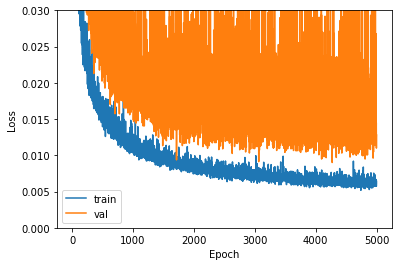

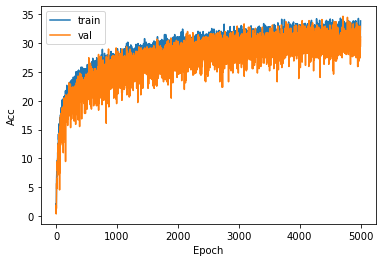

In [85]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.ylim(0, 0.03)
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_loss, label="train")
plt.plot(x, val_loss, label='val')
plt.legend()
plt.show()

plt.figure()
plt.ylabel("Acc")
plt.xlabel("Epoch")
# plt.ylim(0, 0.01)
x = np.arange(1, len(train_loss)+1)
plt.plot(x, train_acc, label="train")
plt.plot(x, val_acc, label='val')
plt.legend()
plt.show()

## Correlation of Ground Truth and Prediction

In [86]:
test_loss, correct = 0, 0
with torch.no_grad():
    pred = model(x_val)
    target = y_val.unsqueeze(1)
    test_loss += loss_fn(pred, target).item()
    correct = torch.sum((torch.abs(pred[:, 0] - target[:, 0]) < torch.abs(0.1* target[:, 0]))).item()

correct /= len(x_val)
test_loss /=  len(x_val)
print("Loss:", test_loss)
print("Accuracy:", correct)

Loss: 0.004026596293304906
Accuracy: 0.32765151515151514


Corr: 0.9921
Loss: 0.0040


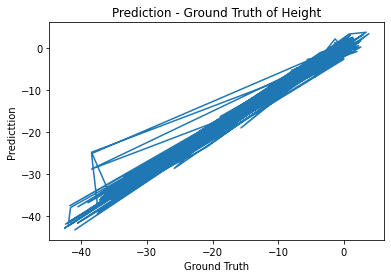

In [87]:
from scipy.stats import pearsonr

# print(y_val.cpu().shape)
# print(pred.cpu().numpy()[:,0])
plt.title( "Prediction - Ground Truth of Height")
plt.xlabel( "Ground Truth")
plt.ylabel( "Predicttion")
plt.plot( y_val.cpu().numpy(), pred.cpu().numpy()[:,0] )# plot( x, y)
corr, _ = pearsonr(y_val.cpu().numpy(), pred.cpu().numpy()[:,0])
slope = "Corr: " + "%.4f"%corr + "\nLoss: " + "%.4f"%test_loss
print(slope)
# plt.text( 0, , slope)
plt.show()

In [88]:
val_1 = pred.cpu().numpy()[:,0]
val_2 = y_val.cpu().numpy()
for i in range(len(val_1)):
    print(val_1[i], '\t', val_2[i], '\t', np.abs(val_1[i]-val_2[i]))

1.2955141 	 -0.26800305 	 1.5635171
1.2860467 	 2.258155 	 0.97210836
-4.8787713 	 -3.2849498 	 1.5938215
-35.86964 	 -36.983746 	 1.1141052
1.5300479 	 1.192615 	 0.33743286
0.70174927 	 0.00163 	 0.70011926
-16.620924 	 -18.295378 	 1.6744537
1.6803217 	 0.28146845 	 1.3988533
-0.3775764 	 0.12780695 	 0.5053834
-18.506752 	 -18.170473 	 0.33627892
-3.2570596 	 -4.1620617 	 0.9050021
-3.4304657 	 -4.003326 	 0.57286024
-37.216537 	 -37.563587 	 0.3470497
-25.203312 	 -38.43539 	 13.232079
-1.2071706 	 -2.762604 	 1.5554334
-0.6102737 	 0.66867894 	 1.2789526
-4.305045 	 -4.4025917 	 0.09754658
-4.7564025 	 -4.003326 	 0.75307655
-18.595694 	 -20.722235 	 2.1265411
1.9906042 	 0.46407846 	 1.5265257
-2.5278535 	 -0.850808 	 1.6770455
-1.694284 	 -0.908169 	 0.786115
-0.3968103 	 -0.11103595 	 0.28577435
-0.26585132 	 -0.503638 	 0.23778671
-21.771307 	 -22.053795 	 0.28248787
-0.62082595 	 -1.4571638 	 0.83633786
-0.9503711 	 -0.30256695 	 0.64780414
0.65624386 	 -1.346593 	 2.002837


In [89]:
print("Saving model weight...")
torch.save(model, "./EEGNet_model.pt")
print("Save Done!")

Saving model weight...
Save Done!
